**AHMED KAMAL, DHRUV JOSHI**

Extensions for project 5

**Extension plan:** Load BERT Classifier, the word classifier that took the field of NLP by storm, resulting in reimplementations in many previous problems and improving benchmarks in most of them with minor changes to the model. Then use the classifier to generate a som word map and qualitatively compare the results to ours.

Although I consulted many resources for this extension, the main one is a guide to use the pretrained model: https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#what-is-bert

In [1]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import matplotlib.pyplot as plt
import os
import sys
import random
import numpy as np
import pandas as pd


plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

First let us take a look at the way the tokenizer for bert works on sentences. The Bert model expects inputs of a sentence long along with \[CLS\] and \[SEP\] tags to indicate the start and the end of sentences respectively. We also see the conversion of words into subsections of the word.

In [2]:
test_text = "I am dying to see the embeddings of this model, first the tokenizer."
test_text = "[CLS] "+test_text+" [SEP]"

test_tokens = tokenizer.tokenize(test_text)
print(test_tokens)

['[CLS]', 'i', 'am', 'dying', 'to', 'see', 'the', 'em', '##bed', '##ding', '##s', 'of', 'this', 'model', ',', 'first', 'the', 'token', '##izer', '.', '[SEP]']


In [3]:
# get indexes of all the tokenized words
indexed_tokens = tokenizer.convert_tokens_to_ids(test_tokens)

# 1 to indicate that all words belong to the same and only sentence we have
segments = [1]*len(test_tokens)

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensor = torch.tensor([segments])

In [4]:
print(tokens_tensor)
print(segments_tensor)

tensor([[  101,  1045,  2572,  5996,  2000,  2156,  1996,  7861,  8270,  4667,
          2015,  1997,  2023,  2944,  1010,  2034,  1996, 19204, 17629,  1012,
           102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [5]:
# load model
model = BertModel.from_pretrained('bert-base-uncased')

# Enable forward pass
model.eval()

print("model ready")

model ready


In [6]:
# get all node activation values
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensor)

In [7]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 21
Number of hidden units: 768


In [8]:
token_embeddings = torch.stack(encoded_layers, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings = token_embeddings.permute(1,0,2)

print(token_embeddings.size())

def process_layers(encoded_layers):
    # making the function for later use
    token_embeddings = torch.stack(encoded_layers, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    token_embeddings = token_embeddings.permute(1,0,2)

    return token_embeddings

torch.Size([21, 12, 768])


Now, it turns out that the resulting features from the different layers can be combined to give different feature vectors. It also turns out that using different combinations is more favorable for different tasks, so time permitting, we will look into which combination will work best for our tasks!

For the first one, we will sum the last 3 layers to maintain 768 features, and then only use 200 of the features so that our SOM does not kill my computer.

In [41]:
def get_feature_vec(token_embeddings):
    new_feature_vecs = []
    for token in token_embeddings:
        # token is a (12 x 768) tensor | new_vec has 200 features
        new_vec = torch.sum(token[-3:,:200], dim=0)

        new_feature_vecs.append(torch.tensor(new_vec))
 
    return torch.stack(new_feature_vecs)



new_feature_vecs = get_feature_vec(token_embeddings)
print(new_feature_vecs.shape)
print ('Shape of new feature vectors: %d x %d' % (len(new_feature_vecs), len(new_feature_vecs[0])))

torch.Size([13, 200])
Shape of new feature vectors: 13 x 200


/Users/dhruv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Load and pre process imdb data

In [42]:
import word2vec

def load_imdb_data(filepath):
    df = pd.read_csv(filepath, delimiter='\t', usecols=[2])
    df = df["review"].tolist()
    return df

data = load_imdb_data('data/imdb/imdb_train.csv')

R = 10
reviews = data[:R]

def pre_bert_tokenizer(data):
    processed_data = []
    for data_point in data:
        data_point = data_point.replace("<br /><br />", " ").replace("\\", "").replace(".", ". [SEP]")
        sents = data_point.split(". [SEP]")
        for sent in sents:
            sent = "[CLS] "+ sent + ". [SEP]"
            token = tokenizer.tokenize(sent)
            if len(token) < 5:
                # skip small sentences / errors in preprocessing
                continue    
            processed_data.append(token)
            
    return processed_data

        
bert_reviews = pre_bert_tokenizer(reviews)
bert_data_indexed = []
bert_data_segments = []
for sentence in bert_reviews:
    indexed_tokens = tokenizer.convert_tokens_to_ids(sentence)
    segments = [1]*len(sentence)

    bert_data_indexed.append(torch.tensor([indexed_tokens]))
    bert_data_segments.append(torch.tensor([segments]))


In [43]:
corpus = word2vec.make_corpus(reviews)
unique_words = word2vec.find_unique_words(corpus)
vocab_sz = len(unique_words)
word2ind = word2vec.make_word2ind_mapping(unique_words)
ind2word = word2vec.make_ind2word_mapping(unique_words)
targets_onehot, contexts_int = word2vec.make_target_context_word_lists(corpus, word2ind, vocab_sz)

Time for the magic, we run all the sentences through the model to get the feature vectors for each word, and then store those in the output list. We can then access them with the corresponding words from the bert reviews.

In [44]:
output = []
for idx_segs in zip(bert_data_indexed, bert_data_segments):
    with torch.no_grad():
        encoded_layers, _ = model(idx_segs[0], idx_segs[1])
    token_embeddings = process_layers(encoded_layers)
    vec = get_feature_vec(token_embeddings)
    output.append(vec)

/Users/dhruv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [45]:
print(output[1].shape)
print(len(bert_reviews[1]))

torch.Size([37, 200])
37


Now, for each unique word, we find the first feature vector for that word and put save it in the word vectors.

In [46]:
word_vecs = []
for word in unique_words:
    found = False
    for i, review in enumerate(bert_reviews):
        for j, review_word in enumerate(review):
            if word == review_word:
                word_vecs.append(output[i][j].numpy())
                found = True
                break
        if found:
            break
            
print(word_vectors[0].shape)

word_vectors = np.asarray(word_vecs)
print(word_vectors.shape)
                            

(768,)
(847, 200)


Now, we use the feature vectors and the unique words to create the SOMs

100.00% complete



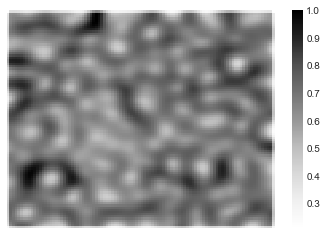

In [48]:
# Make SOM here, train it, etc
import som 

np.random.seed(0)
word_som = som.SOM(100, 200, 100000, init_lr=2, init_sigma=40.0, verbose=False)
word_som.fit(word_vectors.copy())
word_u_map = word_som.u_matrix()

plt.pcolor(word_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

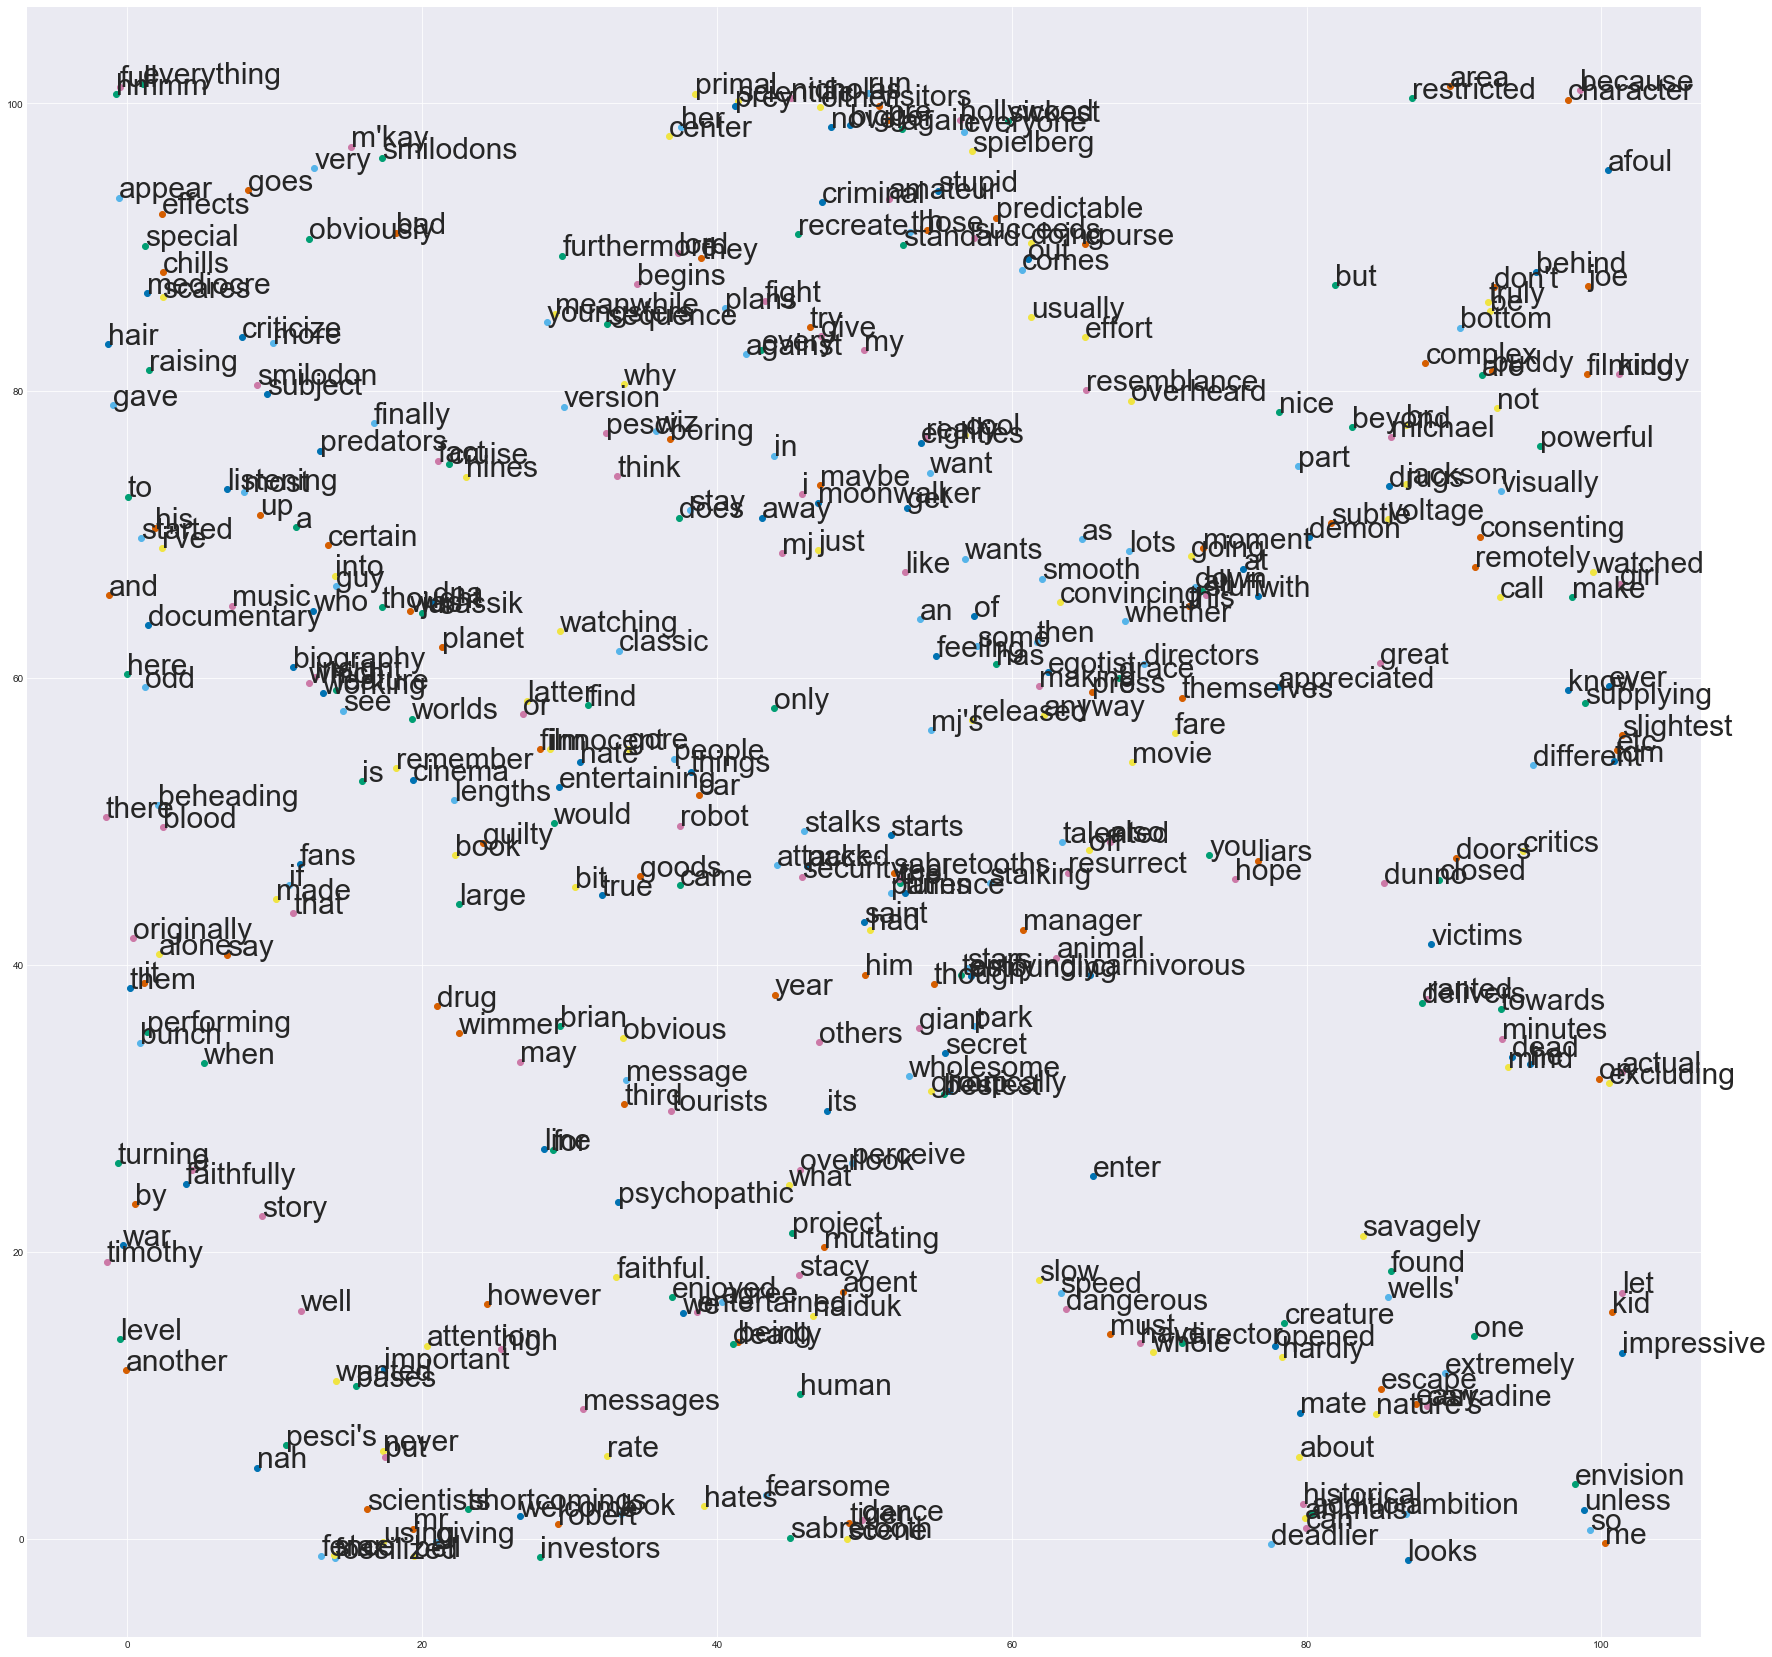

In [50]:
num_words_to_visualize = 400
jitter = 2

fig, ax = plt.subplots(figsize=(30, 30))
for i in range(len(word_vectors[:num_words_to_visualize])):
    bmu_pos = word_som.get_bmu(word_vectors[i])
    # jitter the placement of words so that they are less likely to plot ontop of each other
    x = bmu_pos[0] + 0.5 + jitter*(2*np.random.random()-1)
    y = bmu_pos[1] + 0.5 + jitter*(2*np.random.random()-1)
    ax.scatter(x, y)
    ax.annotate(str(unique_words[i]), (x, y), fontsize=30)
plt.show()

Now, we will use the first 50 reviews from the IMDB data set to see how that impacts the SOM U matrix

/Users/dhruv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


(2350, 20)
100.00% complete



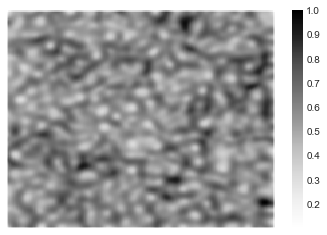

In [53]:
def get_feature_vec_50(token_embeddings):
    new_feature_vecs = []
    for token in token_embeddings:
        # token is a (12 x 768) tensor | new_vec has 20 features
        new_vec = torch.sum(token[-3:,:20], dim=0)

        new_feature_vecs.append(torch.tensor(new_vec))
 
    return torch.stack(new_feature_vecs)

R = 50
reviews_50 = data[:R]
        
bert_reviews_50 = pre_bert_tokenizer(reviews_50)
bert_data_indexed_50 = []
bert_data_segments_50 = []
for sentence in bert_reviews_50:
    indexed_tokens_50 = tokenizer.convert_tokens_to_ids(sentence)
    segments_50 = [1]*len(sentence)

    bert_data_indexed_50.append(torch.tensor([indexed_tokens_50]))
    bert_data_segments_50.append(torch.tensor([segments_50]))
    
    
corpus_50 = word2vec.make_corpus(reviews_50)
unique_words_50 = word2vec.find_unique_words(corpus_50)
vocab_sz_50 = len(unique_words_50)
word2ind_50 = word2vec.make_word2ind_mapping(unique_words_50)
ind2word_50 = word2vec.make_ind2word_mapping(unique_words_50)
targets_onehot_50, contexts_int_50 = word2vec.make_target_context_word_lists(corpus_50, word2ind_50, vocab_sz_50)

output_50 = []
for idx_segs in zip(bert_data_indexed_50, bert_data_segments_50):
    with torch.no_grad():
        encoded_layers_50, _ = model(idx_segs[0], idx_segs[1])
    token_embeddings_50 = process_layers(encoded_layers_50)
    vec_50 = get_feature_vec_50(token_embeddings_50)
    output_50.append(vec_50)
    
word_vecs_50 = []
for word in unique_words_50:
    found = False
# #     print(word)
    for i, review in enumerate(bert_reviews_50):
        for j, review_word in enumerate(review):
            if word == review_word:
#                 print(review_word)
                word_vecs_50.append(output_50[i][j].numpy())
                found = True
                break
        if found:
#             print("found")
            break


word_vectors_50 = np.asarray(word_vecs_50)
print(word_vectors_50.shape)

np.random.seed(0)
word_som_50 = som.SOM(200, 20, 100000, init_lr=2, init_sigma=40.0, verbose=False)
word_som_50.fit(word_vectors_50.copy())
word_u_map_50 = word_som_50.u_matrix()

plt.pcolor(word_u_map_50.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

It turns out I may have bitten off more than I could chew. The BERT encoder is powerful and also derives its most of this power from encoding words based on the context, that means that the model would classify the same word differently depending on what context it appeard on. Given more time and more computational power, I would take all occurrances of a word and then run clustering on the results based on their Cosine distance as a word may have 2 meanings. I could then use these two different values for two different words. For example, "bank" can mean a place that money is stored or the bank of river. If not this, I would try averaging the values to retain some information from all meanings of the word.

Given more computational power, I would also like to see the significant improvements using all 768 feature values (if not more using the last 3 or 4 layers of the model) would get. 